In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from importlib import reload


import config, data, models, train, evaluate

In [2]:
exp_root = Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/reservoirs")
exp_dirs = [p.parent for p in exp_root.rglob('test_data.pkl')] # dirs with test_data.pkl

# exp_dirs = [exp_dirs[i] for i in [-1, 0, 2, 1, -2]]
# exp_dirs = [exp_dirs[i] for i in [3, 2, 1]]

fig_dir = exp_root / "_figures"
fig_dir.mkdir(exist_ok=True, parents=True)


exps = []
for exp_dir in exp_dirs:
    with open(exp_dir / "test_data.pkl", 'rb') as f:
        r, bulk_m, basin_m = pickle.load(f)
        for feat in basin_m.columns.get_level_values('Feature').unique():
            lt10 = basin_m[feat]['num_obs'] < 10
            basin_m.loc[lt10, feat] = np.nan

        # Kind of ugly. Removes the date and time stamps.
        exp_name = '_'.join(exp_dir.stem.split('_')[:-2]) 
        print(exp_name)

        exps.append((exp_name, r, bulk_m, basin_m))

exps = sorted(exps, key=lambda x: x[0])

e5
e5_sr_sl_gs


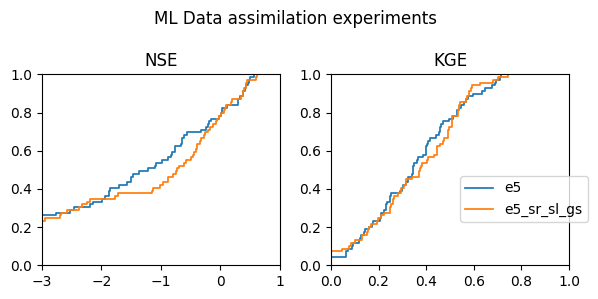

In [5]:
plt.close('all')

num_models = len(exps)

metric_names = {'NSE': 'NSE',
                'KGE': 'KGE'}

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes = axes.flatten()

for ax, (name, title) in zip(axes, metric_names.items()):
    for exp_name, results, bulk_metrics, basin_metrics in exps:
        x = np.array(basin_metrics['discharge'][name], dtype=float)
        x = x[~np.isnan(x)]
        ax.ecdf(x, linewidth=1.25, label=exp_name)
    
    ax.set_title(title)

axes[0].set_xlim([-3, 1])
axes[1].set_xlim([0, 1])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.0, 0.35))

# fig.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.95, wspace=0.3, hspace=0.4)
plt.suptitle('ML Data assimilation experiments')
plt.tight_layout()
plt.show()

fig.savefig(fig_dir / f"ABC_cdfs.png", dpi=300)

In [ ]:
x

In [ ]:
results['obs']['discharge'].groupby('basin').mean().dropna().sort_values()

In [ ]:
basin_metrics['discharge']['NSE'].dropna().sort_values()

metric='NSE'
e5: -27.99
e5_sr_sl_gs: -3.96


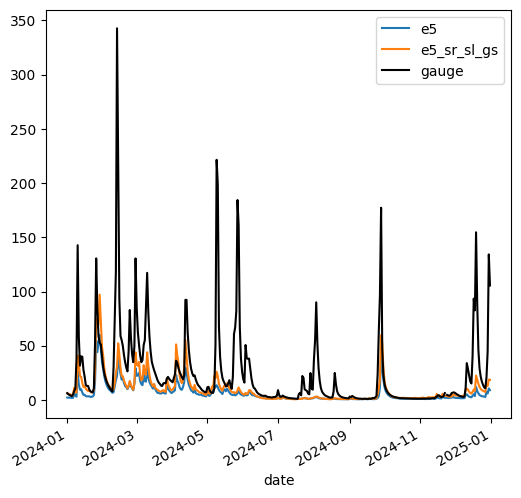

In [6]:
reach_id = 'USGS-03281500'
start_date = "2024-01-01"
end_date = "2025-01-01"
metric = 'NSE'
print(f"{metric=}")

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for exp_name, results, bulk_metrics, basin_metrics in exps: 
    x = results.xs(reach_id, level='basin').sort_index()
    x = x.loc[start_date:end_date]
    x['pred']['discharge'].plot(ax=ax, label=exp_name)
    print(f"{exp_name}: {basin_metrics.loc[reach_id]['discharge'][metric]:0.2f}")
    
x['obs']['discharge'].plot(color='black', ax=ax, label='gauge')
plt.legend()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

exp_idx = 1
name = exps[exp_idx][0]

x = exps[exp_idx][1]['obs']['discharge']
y = exps[exp_idx][1]['pred']['discharge']
positive_mask = (x > 0) & (y > 0)
x = x[positive_mask]
y = y[positive_mask]

min_val = 5E-2
max_val = 5E4
log_min = np.log10(min_val)
log_max = np.log10(max_val)

hb = ax.hexbin(x, y, gridsize=(100,80), bins='log', mincnt=5,
            linewidth=0.1,
            extent=(log_min, log_max, log_min, log_max),
            xscale='log', yscale='log')
plt.colorbar(hb, shrink=0.6, aspect=10, anchor=(0,0.5))

# Add a 1:1 line over the min and max of x and y
ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5)

# Setting axes to be square and equal range
ax.axis('square')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_title(f"{name}: Discharge (n {len(x):,})")
ax.set_xlabel(f'Observed [m3/s]')
ax.set_ylabel(f'Predicted [m3/s]')
plt.show()

fig.savefig(fig_dir / f"{name}_bulk_scatterplots.png", dpi=300)